Импорт библиотек

In [398]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

Путь к дирректории с данными проекта 

In [399]:
path = 'D:/Работы/VAGON/Трек 1 - ПГК Оракул/'

Открываем датафреймов

In [400]:
forecast_example = pd.read_csv(f"{path}forecast_example.csv", sep=";", decimal=",", encoding="windows-1251")
forecast_example = forecast_example.groupby(by='period').agg({'forecast_wagon_count':'sum'})
forecast_example.reset_index(inplace=True)


In [ ]:
fact = pd.read_csv(f"{path}fact_train_test.csv", sep=";", decimal=",", encoding="windows-1251")
fact["period"] = fact["period"].astype("datetime64[ns]")

fact['year'] = fact['period'].dt.year
fact['month'] = fact['period'].dt.month

fact = fact[fact['period'] > '31-12-2017']

In [402]:
gropped = fact.groupby(by='period').agg({'real_wagon_count':'sum'})
gropped.reset_index(inplace=True)
gropped['month'] = gropped['period'].dt.month

In [403]:
def group(name):
    df = pd.read_csv(f"{path}{name}", sep=";", decimal=",", encoding="windows-1251")
    df   = df.groupby(by='period').agg({'forecast_wagon_count':'sum'})
    df.reset_index(inplace=True)
    return df


Открытие и подготовка файлов с результатами

In [405]:
forecast_example_try_ceil = group('forecast_example_try_ceil.csv')
forecast_example_try = group('forecast_example_try.csv')
forecast_example_try1 = group('forecast_example_try1.csv')
forecast_example_try_diff_years_close_to_mean_pred = group('forecast_example_try_diff_years_close_to_mean_pred.csv')
mean_of_month_res = group('mean_of_month_res.csv')
forecast_from_2022 = group('forecast_from_2022.csv')
forecast_from_2021 = group('forecast_from_2021.csv')
forecast_from_koef = group('forecast_from_koef.csv')
forecast_from_koef_01_015_075 = group('forecast_from_koef_01_015_075.csv')
forecast_from_koef_01_025_065 = group('forecast_from_koef_01_025_065.csv')
forecast_from_koef_003 = group('forecast_from_koef_0.03, 0.06, 0.09, 0.12, 0.15, 0.55.csv')
forecast_from_koef_with_seasons = group('forecast_from_koef_with_seasons.csv')

In [406]:
def plot(df, df_name):
    plt.plot(range(gropped.shape[0]-1, gropped.shape[0]+5), np.flip(np.append(df[f'forecast_wagon_count'].values, gropped['real_wagon_count'].values[-1])), label = f'{df_name}')


Визуализация попыток

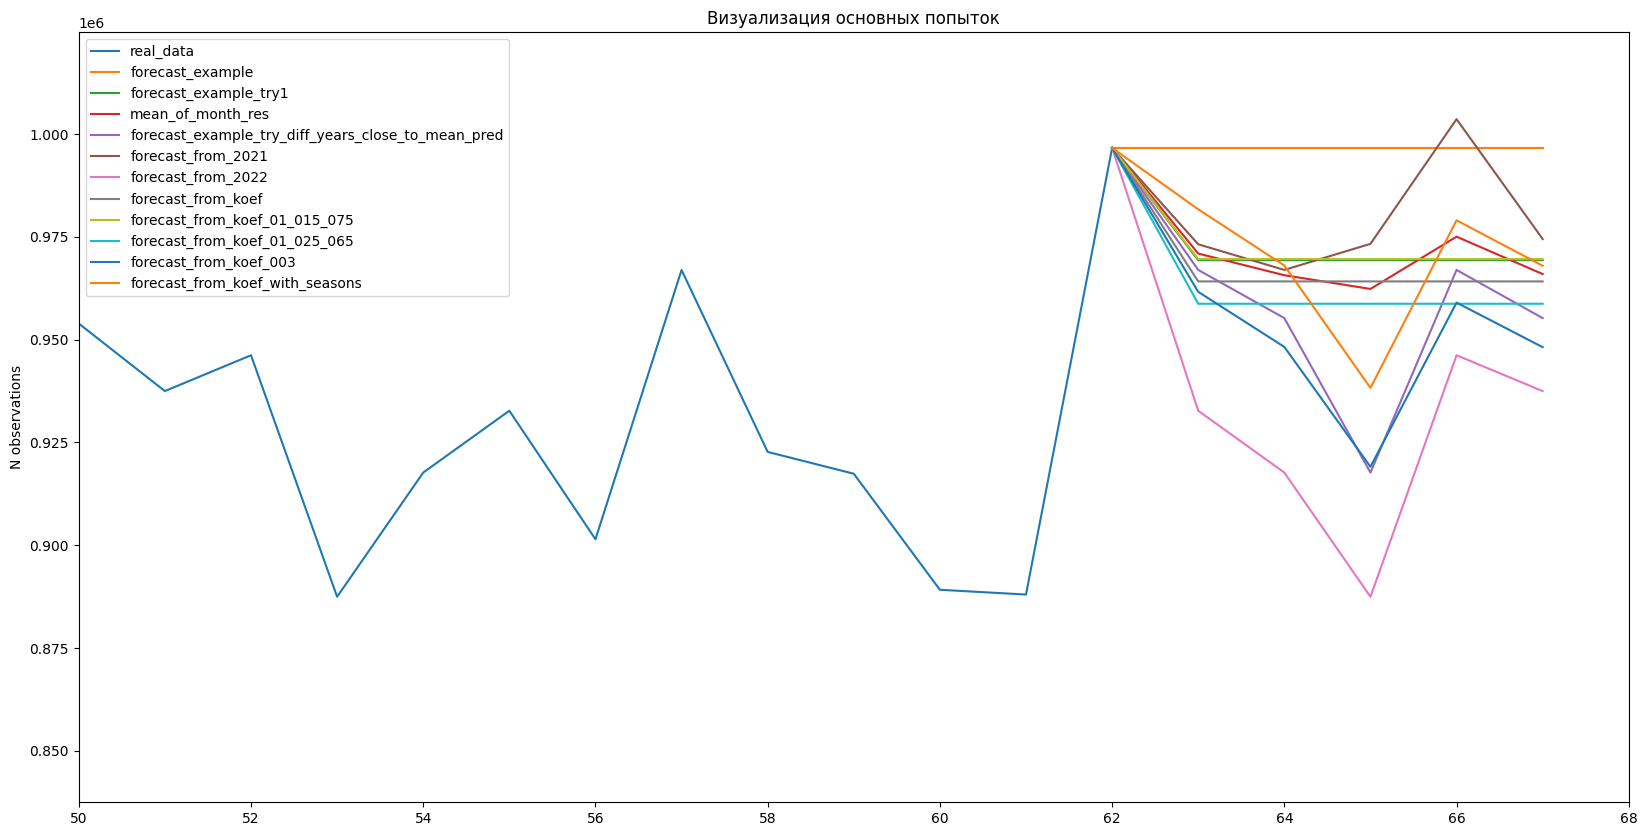

In [407]:
plt.figure(figsize=(20,10))

plt.plot(range(gropped.shape[0]), gropped['real_wagon_count'], label = 'real_data')
plot(forecast_example, 'forecast_example')

plot(forecast_example_try1, 'forecast_example_try1') #1-ая удачкная попытка добавлены коэффиценты отношения значений в марте к историческим данным в предсказываемые месяца
plot(mean_of_month_res, 'mean_of_month_res') # предположение о средних значениях в каждой точке соответвующего месяца иисторических данных 
plot(forecast_example_try_diff_years_close_to_mean_pred, 'forecast_example_try_diff_years_close_to_mean_pred') #выбор знайчений разных месяцев, дающий наиболее бллизкий к 
                                                                                                                   #среднему значению результат
plot(forecast_from_2021, 'forecast_from_2021') #Предсказания по данным 2021 года 
plot(forecast_from_2022, 'forecast_from_2022') #Предсказания по данным 2022 года 
plot(forecast_from_koef, 'forecast_from_koef') #Лучший результат - предсказания по 3-м последним месяцам с весовыми коэффициентами
plot(forecast_from_koef_01_015_075, 'forecast_from_koef_01_015_075') #предсказания по 3-м последним месяцам с весовыми коэффициентами
plot(forecast_from_koef_01_025_065, 'forecast_from_koef_01_025_065') #предсказания по 3-м последним месяцам с весовыми коэффициентами
plot(forecast_from_koef_003, 'forecast_from_koef_003') #предсказания по 6-ти последним месяцам с весовыми коэффициентами
plot(forecast_from_koef_with_seasons, 'forecast_from_koef_with_seasons') #предсказания по 3-м последним месяцам с весовыми и сезонными коэффициентами

plt.ylabel('wagon_count')
plt.ylabel('N observations')
plt.xlim(50, 68)
plt.title('Визуализация основных попыток')
plt.legend()

Визуализация общей картины

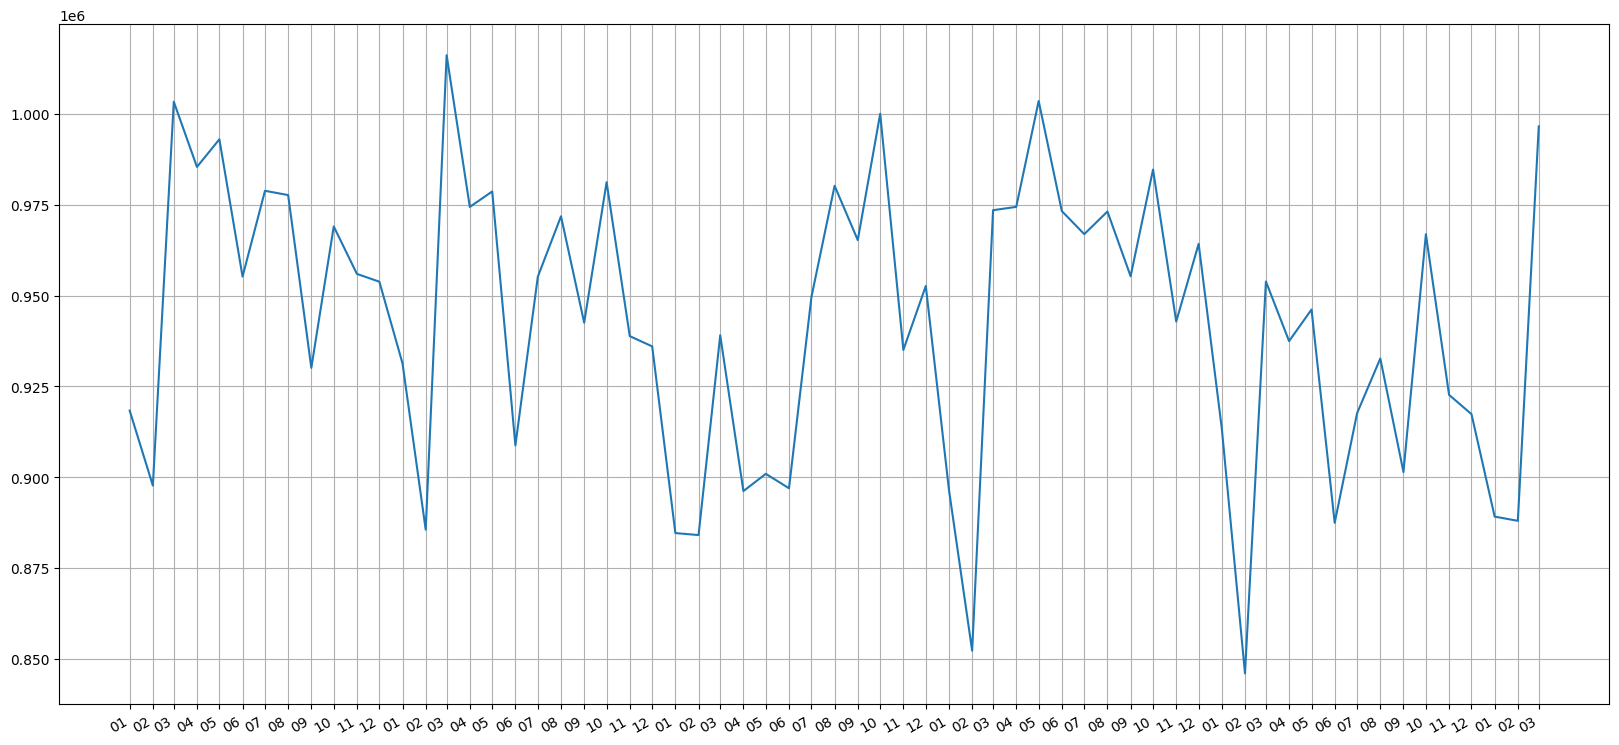

In [371]:
plt.figure(figsize=(20,10))
plt.plot(gropped['period'], gropped['real_wagon_count'], label = 'real_data')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m'))

plt.gca().set_xticks(gropped['period'])

plt.gcf().autofmt_xdate()

plt.gcf().autofmt_xdate()
plt.grid(axis = "x")

plt.grid(axis = "y")


Расчёт коэффицииентов сезонности

In [322]:
koefs1 = []

for i in [4,5,6,7,8]:
    a = np.mean(gropped.query(f'month =={i}')['real_wagon_count']) / np.mean(gropped.query('month == 1')['real_wagon_count']) * 0.1 + \
    np.mean(gropped.query(f'month == {i}')['real_wagon_count']) / np.mean(gropped.query('month == 2')['real_wagon_count']) * 0.2 +\
    np.mean(gropped.query(f'month == {i}')['real_wagon_count']) / np.mean(gropped.query('month == 3')['real_wagon_count']) * 0.7 
    koefs1.append(a)

Прогнозирование

In [366]:
mon_year = ['2023_1', '2023_2', '2023_3']
# mon_year = ['2022_10', '2022_11', '2022_12', '2023_1','2023_2','2023_3']

result = []
last_known_fact_month = fact["period"].max()
test_periods = pd.date_range(start=last_known_fact_month, periods=6, freq='MS', inclusive='right')

koefs = [0.1, 0.2, 0.7] #0.67810780983163
#koefs = [0.1, 0.25, 0.65]
# koefs = [0.03, 0.06, 0.09, 0.12, 0.15, 0.55]

koefs1 = [1.0039449896675405,
 1.0154144596126689,
 0.9731427924138524,
 1.0040113151748233,
 1.0181919191890785]

# koefs1 = [0.9981212020086608,
#  1.0095241386693885,
#  0.9674976853182293,
#  0.9981871427680992,
#  1.012285486471776]

# koefs1 = [1.0097687773264201,
#  1.0213047805559494,
#  0.9787878995094756,
#  1.0098354875815476,
#  1.024098351906381]

# koefs1 = [0.9928650428133431,
#  1.0042079310047445,
#  0.962402791186234,
#  0.9929306363252444,
#  1.0069547374031282]

i = 0
for period in test_periods:
    print(i)
    for p in mon_year:
        month_forecast = fact.query(f'year == {p.split("_")[0]} and month == {p.split("_")[1]}').reset_index(drop=True)
        month_forecast['real_wagon_count'] = month_forecast['real_wagon_count'].values * koefs[mon_year.index(p)] * koefs1[i]
        month_forecast['real_weight'] = month_forecast['real_weight'].values * koefs[mon_year.index(p)] * koefs1[i]
        month_forecast["period"] = period
        result.append(month_forecast)
    i+=1

result = pd.concat(result).reset_index(drop=True)
result.rename(columns={"real_wagon_count": "forecast_wagon_count", "real_weight": "forecast_weight"}, inplace=True)
result.to_csv(f"{path}forecast_from_koef_with_seasons.csv", index=False, sep=";", decimal=",", encoding="windows-1251")

0
1
2
3
4
